# Using pre-trained convnets
We can use the convolutional bases of models pre-trained on the ImageNet databases. Using part of or all of the convolutional base of another model is practicing **feature extraction**. We can later use **fine-tuning** to further improve the model.

In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

This is the pre-trained convolutional base from a **VGG16** architecture model. This convolutional base learns abstract spatial patterns in the input data. Now, we want to classify whether the output is a **cat or dog**, so we can add a densely-connected classifier at the end. 

We have two options: process the output of the convolutional base independently in a classifier, or connect the classifier to the convolutional base. The first option will not allow us to use **data augmentation** because an input image will only be run through the model once, but we have less computations. The second option allows us to use **data augmentation**, but will be more expensive since an image will be run through the base every time the model receives it as input.

# Fast image classification

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
os.listdir('../data')

['kaggle-dogs-cats-data', 'dogs-and-cats-small']

In [6]:
os.listdir('../data/dogs-and-cats-small')

['test', 'train', 'validation']

In [7]:
base_dir = '../data/dogs-and-cats-small'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

We'll make a function here that will extract the feature map from the trained convolutional base above. The feature map will be put in a numpy array to be plugged into a classifier

In [8]:
def extract_features(directory, sample_count):
    # (4, 4, 512) because that's the output shape of the conv. base above
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        # Target size is (150, 150) just like our convnet trained from scratch before
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        # Generates feature maps for first batch of 20 images from the directory parameter
        features_batch = conv_base.predict(inputs_batch)
        # Place the predicted feature maps and labels for the batch into the corresponding numpy arrays, in 20 spaces
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        # If we've seen all images once, then break
        # 'i' is incremented by one each loop and each loop has a batch size of 20 images, as set before,
        # so if 'i * 20' is greater than the desired sample size of images, we exit the loop
        if i * batch_size >= sample_count:
            break
            
    # Returns the numpy arrays of feature maps and corresponding labels
    return features, labels

In [9]:
"""The features are all of shape (sample_count, 4, 4, 512) because they came
straight from the conv. base's prediction. The densely connected classifier only uses
flattened data, so we can flatten the data before putting them in a classifier
"""
train_features, train_labels = extract_features(train_dir, 2000)
valid_features, valid_labels = extract_features(valid_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# Here, we flatten the numpy arrays for densely-connected classification
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
valid_features = np.reshape(valid_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [11]:
# Now we create the densly connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [12]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(valid_features, valid_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 745us/step - loss: 0.5919 - acc: 0.6665 - val_loss: 0.4416 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 0s 242us/step - loss: 0.4328 - acc: 0.8115 - val_loss: 0.3651 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 0s 244us/step - loss: 0.3692 - acc: 0.8405 - val_loss: 0.3320 - val_acc: 0.8590
Epoch 4/30
2000/2000 [==============================] - 0s 245us/step - loss: 0.3203 - acc: 0.8695 - val_loss: 0.3006 - val_acc: 0.8800
Epoch 5/30
2000/2000 [==============================] - 0s 240us/step - loss: 0.2833 - acc: 0.8880 - val_loss: 0.2801 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 0s 241us/step - loss: 0.2618 - acc: 0.9030 - val_loss: 0.2786 - val_acc: 0.8860
Epoch 7/30
2000/2000 [==============================] - 0s 245us/step - loss: 0.2462 - acc: 0.9040 - val_loss: 0.2613 - val_acc: 0.9000


In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

The validation loss is not decreasing, our network is just remembering the data exactly as we input it, and not the patterns in the data. We need to use **data augmentation** since we have a small dataset. This will take much more time, but we should get better results.

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


We now have to freeze the convolutional base so that its weights are not affected. The weights were already set when the VGG16 architecture model was trained on ImageNet, and we don't want to mess those weights up because of the initial inaccuracy of the densely-connected classifier we're putting on top of the base.

In [15]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# This is the data augmentation part, remixing data to create new artificial data
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 22s 215ms/step - loss: 0.6031 - acc: 0.6725 - val_loss: 0.4567 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 21s 208ms/step - loss: 0.4871 - acc: 0.7860 - val_loss: 0.3756 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 20s 197ms/step - loss: 0.4470 - acc: 0.7975 - val_loss: 0.3381 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 20s 204ms/step - loss: 0.4131 - acc: 0.8150 - val_loss: 0.3145 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3907 - acc: 0.8220 - val_loss: 0.2990 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 21s 208ms/step - loss: 0.3717 - acc: 0.8395 - val_loss: 0.2864 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 20s 196ms/step - loss: 0.3583 - acc: 0.8390 - val_loss: 0.2757 - val_acc: 0.8890
Epoch 8/30
100/100 [==============================] - 2

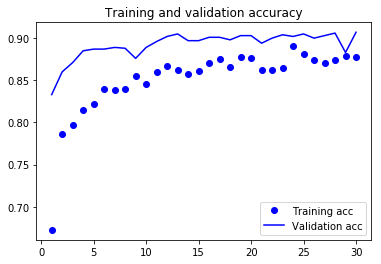

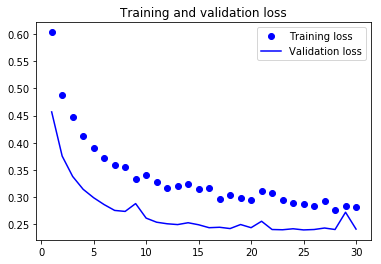

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Remember that we froze the entire convolutional base to train a densely-connected classifier on top. Once we trained this densely-connected classifier, we can now unfreeze some layers in the base to retrain them to our new data. The earlier parts of the convolutional base find patterns like edges, textures, and colors. The later parts of the convolutional base find larger patterns, like eyes or the sky. The earlier layers are likely to be common to many CV problems; the later layers can be changed a little since they are specialized to each problem, or **fine-tuned**, to this problem.

Also, the convolutional base has 14.7 million parameters, and we only have 2000 images w/ data augmentation, so we would run a risk of overfitting if we retrained all the layers of the base, because of the ratio of parameters to data.

In [33]:
conv_base.trainable = True # <-- Make sure to make the whole base trainable first before setting individual layers

# conv_base.layers is a list of layers in the conv_base model
for layer in conv_base.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7fb1081685c0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07e6506d8> False
<keras.layers.convolutional.Conv2D object at 0x7fb07e6506a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb07e6507f0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07e67ce48> False
<keras.layers.convolutional.Conv2D object at 0x7fb07de22f60> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb07de3c320> False
<keras.layers.convolutional.Conv2D object at 0x7fb07dddf5c0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07dd82fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07dd9c518> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb07ddbe7f0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07dd5d5c0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07dd80fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fb07dd1a518> False
<keras.layers.pooling.MaxPooling2D object at 0x7fb07dd3a7f0> Fa

In [35]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [38]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 23s 227ms/step - loss: 0.5549 - acc: 0.7190 - val_loss: 0.4306 - val_acc: 0.7900
Epoch 2/100
100/100 [==============================] - 20s 201ms/step - loss: 0.3822 - acc: 0.8445 - val_loss: 0.2740 - val_acc: 0.8790
Epoch 3/100
100/100 [==============================] - 21s 208ms/step - loss: 0.3334 - acc: 0.8510 - val_loss: 0.2287 - val_acc: 0.9080
Epoch 4/100
100/100 [==============================] - 20s 202ms/step - loss: 0.3001 - acc: 0.8665 - val_loss: 0.2356 - val_acc: 0.8980
Epoch 5/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2681 - acc: 0.8855 - val_loss: 0.1979 - val_acc: 0.9080
Epoch 6/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2576 - acc: 0.8920 - val_loss: 0.1945 - val_acc: 0.9160
Epoch 7/100
100/100 [==============================] - 21s 206ms/step - loss: 0.2442 - acc: 0.8980 - val_loss: 0.1907 - val_acc: 0.9210
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 21s 207ms/step - loss: 0.0436 - acc: 0.9865 - val_loss: 0.2122 - val_acc: 0.9340
Epoch 62/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0374 - acc: 0.9895 - val_loss: 0.2891 - val_acc: 0.9270
Epoch 63/100
100/100 [==============================] - 21s 209ms/step - loss: 0.0504 - acc: 0.9800 - val_loss: 0.1801 - val_acc: 0.9410
Epoch 64/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0497 - acc: 0.9855 - val_loss: 0.1946 - val_acc: 0.9410
Epoch 65/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0385 - acc: 0.9855 - val_loss: 0.2122 - val_acc: 0.9440
Epoch 66/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0431 - acc: 0.9860 - val_loss: 0.2381 - val_acc: 0.9250
Epoch 67/100
100/100 [==============================] - 21s 208ms/step - loss: 0.0348 - acc: 0.9860 - val_loss: 0.2084 - val_acc: 0.9410
Epoch 68/100
100/100 [===================

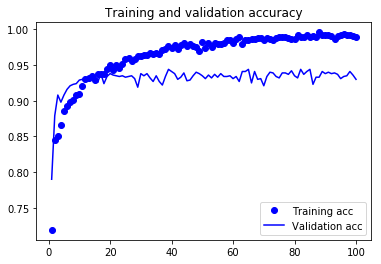

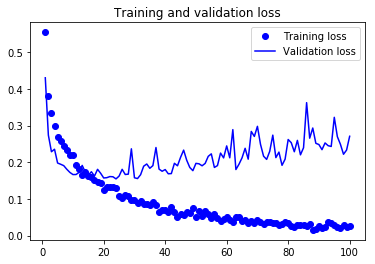

In [39]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
train_dir = os.path.join(base_dir, 'train')
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

Found 1000 images belonging to 2 classes.


In [42]:
test_acc

0.9349999916553497